In [126]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pygeohydro import WBD
from pynhd import NHD
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from shapely.ops import snap

In [5]:
wbd = WBD("huc4")
subregion = wbd.byids("huc4", 1804)
subregion

,geometry,OBJECTID,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,areaacres,areasqkm,states,huc4,name,shape_Length,shape_Area,referencegnis_ids
0,"POLYGON ((-120.54011 38.75127, -120.54153 38.7...",87,{419D90DC-A7AA-4C8F-8269-2C3F59883D1F},{A0039473-A809-4129-8E12-32F32F5B835C},None,U.S. Geological Survey,None,1641219159000,10127904.92,40986.21,CA,1804,San Joaquin,1.643854e+06,6.553432e+10,None


In [10]:
fields = [
    'COMID',
    'LENGTHKM',
    'ArbolateSu',
    'SLOPE',
]

nhd = NHD('flowline_mr', outfields = fields)
aoi = subregion['geometry'].iloc[0]
flowlines = nhd.bygeom(aoi)
flowlines

,geometry,COMID,LENGTHKM,ArbolateSu,SLOPE
0,"LINESTRING (-120.11581 37.16139, -120.11735 37...",19772077,0.475,565.812,0.002926
1,"LINESTRING (-120.11238 37.16407, -120.11281 37...",19772079,1.036,557.847,0.001364
2,"LINESTRING (-120.01840 37.17531, -120.01866 37...",19772139,7.276,7.276,0.008793
3,"LINESTRING (-120.04124 37.13242, -120.04070 37...",19772159,1.606,11.969,0.002696
4,"LINESTRING (-120.04728 37.12531, -120.04739 37...",19772169,1.354,38.094,0.001411
...,...,...,...,...,...
19999,"LINESTRING (-120.10658 37.16306, -120.10766 37...",19772053,0.583,2.322,0.002041
20000,"LINESTRING (-120.09811 37.16507, -120.09903 37...",19772055,1.103,5.808,0.002058
20001,"LINESTRING (-120.10658 37.16306, -120.10669 37...",19772057,0.315,2.054,0.002970
20002,"LINESTRING (-120.11312 37.16302, -120.11338 37...",19772065,0.301,559.571,0.000133


In [20]:
flowlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
flowlines = flowlines.to_crs("EPSG:3310")
flowlines.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [26]:
flowlines['LENGTHKM'].describe()

count    20004.000000
mean         1.551437
std          1.577570
min          0.001000
25%          0.492000
50%          1.192000
75%          2.079000
max         33.343000
Name: LENGTHKM, dtype: float64

In [27]:
top = flowlines.head(5)

In [28]:
top

,geometry,COMID,LENGTHKM,ArbolateSu,SLOPE
0,"LINESTRING (-10270.103 -95036.427, -10407.048 ...",19772077,0.475,565.812,0.002926
1,"LINESTRING (-9965.485 -94739.319, -10003.511 -...",19772079,1.036,557.847,0.001364
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793
3,"LINESTRING (-3658.507 -98262.749, -3610.323 -9...",19772159,1.606,11.969,0.002696
4,"LINESTRING (-4194.469 -99052.851, -4204.607 -9...",19772169,1.354,38.094,0.001411


In [29]:
first = top.iloc[0]
first

geometry      LINESTRING (-10270.103356920677 -95036.4274285...
COMID                                                  19772077
LENGTHKM                                                  0.475
ArbolateSu                                              565.812
SLOPE                                                  0.002926
Name: 0, dtype: object

In [168]:
line = first['geometry']
splitter = MultiPoint([line.interpolate((i/2), normalized=True) for i in range(1, 2)])
snapped = snap(line, splitter, tolerance=0.01) # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
# https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
splitted = split(snapped, splitter).geoms
len(splitted)

2

In [162]:
 p = gpd.GeoSeries(splitted)
 p

0    LINESTRING (-10270.103 -95036.427, -10407.048 ...
1    LINESTRING (-10494.739 -95113.952, -10602.378 ...
dtype: geometry

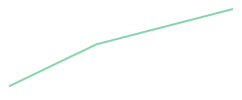

In [164]:
p.iloc[0]

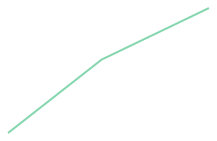

In [165]:
p.iloc[1]

In [169]:
line.length

477.4565004354849

In [180]:
distance_delta = 100
distances = np.arange(0, line.length, distance_delta)
points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
#multipoint = unary_union(points)  # or new_line = LineString(points)

In [181]:
points

[<POINT (-10270.103 -95036.427)>,
 <POINT (-10366.919 -95061.461)>,
 <POINT (-10459.828 -95097.186)>,
 <POINT (-10549.971 -95140.478)>,
 <POINT (-10635.321 -95191.478)>,
 <POINT (-10696.274 -95239.271)>]

In [184]:
type(shapely.unary_union(points))

shapely.geometry.multipoint.MultiPoint

In [185]:
type(splitter)

shapely.geometry.multipoint.MultiPoint

In [218]:
def segment(line, length=500, method="remainder"):
    # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
    # https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
    distances = np.arange(0, line.length, length)
    points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
    points = shapely.unary_union(points)
    snapped = snap(line, points, tolerance=0.01) 
    return list(split(snapped, points).geoms)

In [217]:
top

,geometry,COMID,LENGTHKM,ArbolateSu,SLOPE
0,"LINESTRING (-10270.103 -95036.427, -10407.048 ...",19772077,0.475,565.812,0.002926
1,"LINESTRING (-9965.485 -94739.319, -10003.511 -...",19772079,1.036,557.847,0.001364
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793
3,"LINESTRING (-3658.507 -98262.749, -3610.323 -9...",19772159,1.606,11.969,0.002696
4,"LINESTRING (-4194.469 -99052.851, -4204.607 -9...",19772169,1.354,38.094,0.001411


In [229]:
top['segments'] = top['geometry'].apply(segment)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [233]:
top.explode('segments')

,geometry,COMID,LENGTHKM,ArbolateSu,SLOPE,segments
0,"LINESTRING (-10270.103 -95036.427, -10407.048 ...",19772077,0.475,565.812,0.002926,LINESTRING (-10270.103356920677 -95036.4274285...
1,"LINESTRING (-9965.485 -94739.319, -10003.511 -...",19772079,1.036,557.847,0.001364,LINESTRING (-9965.485493607392 -94739.31932203...
1,"LINESTRING (-9965.485 -94739.319, -10003.511 -...",19772079,1.036,557.847,0.001364,LINESTRING (-10447.949805556089 -94839.2488464...
1,"LINESTRING (-9965.485 -94739.319, -10003.511 -...",19772079,1.036,557.847,0.001364,LINESTRING (-10709.804471029087 -95202.9135867...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-1631.497186241981 -93495.08193291...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-1965.2998117039892 -93656.1385713...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-2355.5249434694515 -93863.4472377...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-2461.256037580678 -94286.63322034...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-2635.3482234026783 -94749.9276580...
2,"LINESTRING (-1631.497 -93495.082, -1654.363 -9...",19772139,7.276,7.276,0.008793,LINESTRING (-2901.797741717885 -95170.07104403...
